<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pytorch-Introduction" data-toc-modified-id="Pytorch-Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pytorch Introduction</a></span><ul class="toc-item"><li><span><a href="#Example-1---Linear-Regression" data-toc-modified-id="Example-1---Linear-Regression-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Example 1 - Linear Regression</a></span></li><li><span><a href="#Example-2" data-toc-modified-id="Example-2-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Example 2</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

%watermark -a 'Ethen' -d -t -v -p numpy,matplotlib,torch

Ethen 2018-02-07 05:56:03 

CPython 3.6.3
IPython 6.1.0

numpy 1.14.0
sklearn 0.19.1
matplotlib 2.1.0
torch 0.3.0.post4


# Pytorch Introduction

```bash
# installation on a mac
# for more information on installation refer to
# the following link:
# http://pytorch.org/
conda install pytorch torchvision -c pytorch 
```

At its core, PyTorch provides two main features:

- An n-dimensional Tensor, similar to numpy array but can run on GPUs. PyTorch provides many functions for operating on these Tensors, thus it can be used as a general purpose scientific computing tool.
- Automatic differentiation for building and training neural networks.

Let's dive in by looking at some examples:

## Example 1 - Linear Regression

In [2]:
# make up some trainig data and specify the type to be float, i.e. np.float32
# We DO not recommend double, i.e. np.float64, especially on the GPU. GPUs have bad
# double precision performance since they are optimized for float32
X_train = np.asarray([3.3, 4.4, 5.5, 6.71, 6.93, 4.168, 9.779, 6.182, 7.59, 
                      2.167, 7.042, 10.791, 5.313, 7.997, 5.654, 9.27, 3.1], dtype = np.float32)
X_train = X_train.reshape(-1, 1)
y_train = np.asarray([1.7, 2.76, 2.09, 3.19, 1.694, 1.573, 3.366, 2.596, 2.53, 
                      1.221, 2.827, 3.465, 1.65, 2.904, 2.42, 2.94, 1.3], dtype = np.float32)

# Convert numpy array to Pytorch Tensors to hold input and outputs
# and wrap them into Variables. Variables wraps a Tensor and records
# the history of operations applied to it, i.e. it can record the
# gradients. Here we're setting requires_grad = False as it indicates
# we do not need to compute gradients with respect to these Variables
# during the backward pass
X = Variable(torch.from_numpy(X_train), requires_grad = False)
y = Variable(torch.from_numpy(y_train), requires_grad = False)

Here we start defining the linear regression model, recall that in linear regression, we are optimizing for the squared loss.

\begin{align}
L = \frac{1}{2}(y-(Xw + b))^2
\end{align}

In [3]:
# with linear regression, we apply a linear transformation
# to the incoming data, i.e. y = Xw + b, here we only have a 1
# dimensional data, thus the feature size will be 1
model = nn.Linear(in_features = 1, out_features = 1)

# although we can write our own loss function, the nn module
# also contains definitions of popular loss functions; here
# we use the MSELoss, a.k.a the L2 loss, and size_average parameter
# simply divides it with the number of examples
criterion = nn.MSELoss(size_average = True)

# Then we use the optim module to define an Optimizer that will update the weights of
# the model for us. Here we will use SGD; but it contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer the parameters that it should update
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [4]:
# start the optimization process
n_epochs = 100
for _ in range(n_epochs):
    # torch accumulates the gradients, thus before running new things
    # use the optimizer object to zero all of the gradients for the
    # variables it will update (which are the learnable weights of the model),
    # think in terms of refreshing the gradients before doing the another round of update
    optimizer.zero_grad()

    # forward pass: compute predicted y by passing X to the model
    output = model(X)

    # compute the loss function
    loss = criterion(output, y)

    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # call the step function on an Optimizer makes an update to its parameters
    optimizer.step()

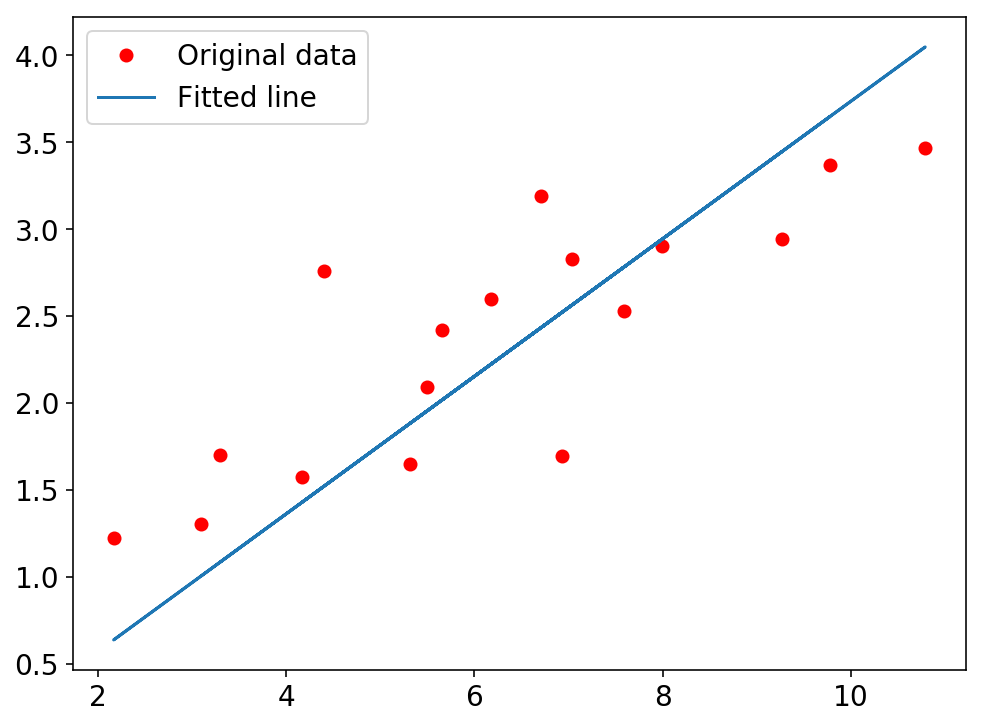

In [5]:
# plot the data and the fitted line to confirm the result

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 14

# access the data of the torch Variable,
# which will be a torch FloatTensor and
# convert it back to a numpy ndarray
y_pred = model(X).data.numpy()
plt.plot(X_train, y_train, 'ro', label = 'Original data')
plt.plot(X_train, y_pred, label = 'Fitted line')
plt.legend()
plt.show()

In [6]:
# to get the parameters, i.e. weight and bias from the model,
# we can use the state_dict() attribute from the model that
# we've defined
model.state_dict()

OrderedDict([('weight', 
               0.3955
              [torch.FloatTensor of size 1x1]), ('bias', 
              -0.2212
              [torch.FloatTensor of size 1])])

In [7]:
# or we could get it from the model's parameter
# which by itself is a generator
param_list = list(model.parameters())
print(param_list[0].data, param_list[1].data)


 0.3955
[torch.FloatTensor of size 1x1]
 
-0.2212
[torch.FloatTensor of size 1]



In [8]:
class LinearRegression(nn.Module):
    """
    A better way of defining our model is to
    inherit the nn.Module class, to use it all
    we need to do is define our model's forward
    pass and the nn.Module will automatically
    define the backward method for us, where the
    gradients will be computed using autograd
    """
    def __init__(self, in_features, out_features):
        super().__init__()  # boilerplate call
        self.in_features = in_features
        self.out_features = out_features
        self.linear = nn.Linear(in_features, out_features)  

    def forward(self, x):
        out = self.linear(x)
        return out


# same optimization process
n_epochs = 100
learning_rate = 0.01
criterion = nn.MSELoss(size_average = True)
model = LinearRegression(in_features = 1, out_features = 1)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(n_epochs):
    # forward + backward + optimize
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    # print the loss per 20 epoch this time
    if (epoch + 1) % 20 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, n_epochs, loss.data[0]))

Epoch [20/100], Loss: 0.2191
Epoch [40/100], Loss: 0.2130
Epoch [60/100], Loss: 0.2075
Epoch [80/100], Loss: 0.2026
Epoch [100/100], Loss: 0.1981


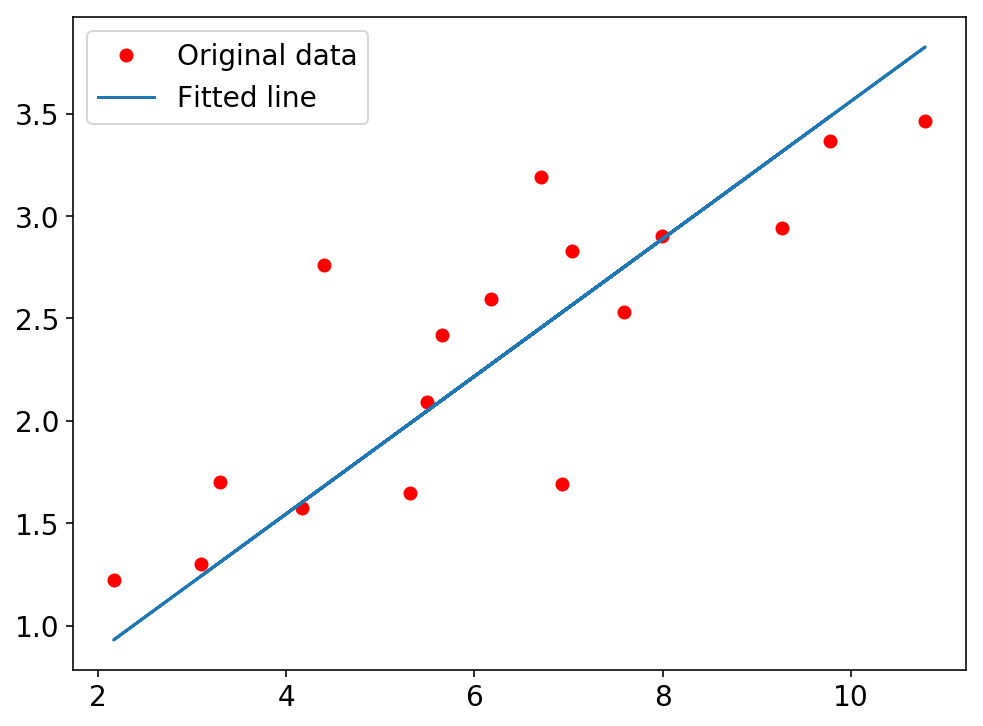

In [9]:
# we can also save the model's parameter and load it back into the model
# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch
checkpoint_path = 'model.pkl'
torch.save(model.state_dict(), checkpoint_path)
model.load_state_dict(torch.load(checkpoint_path))

y_pred = model(X).data.numpy()
plt.plot(X_train, y_train, 'ro', label = 'Original data')
plt.plot(X_train, y_pred, label = 'Fitted line')
plt.legend()
plt.show()

## Example 2

In [10]:
# Any operation that mutates a tensor in-place is post-fixed with an _.
# For example: x.copy_(y), x.t_(), will change x

# Tensors can be moved onto GPU using the .cuda method
# let us run this cell only if CUDA is available
# if torch.cuda.is_available():
#     x = x.cuda()
#     y = y.cuda()

# tensor and variable shares the same memory, thus there's no need to
# delete the tensor after 
# https://discuss.pytorch.org/t/tensor-to-variable-and-memory-freeing-best-practices/6000/2

# Reference

- [Github: PyTorch Tutorial for Deep Learning Researchers](https://github.com/yunjey/pytorch-tutorial)
- [PyTorch Documentation: Deep Learning with PyTorch: A 60 Minute Blitz](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)